In [1]:
import requests
import pandas as pd
import numpy as np
import math
import json
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, NumeralTickFormatter, HoverTool
from bokeh.models.widgets import Tabs, Panel
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from IPython.display import Markdown as md
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf

# Initialize Bokeh for charts
output_notebook()

Loading BokehJS ...

In [2]:
# Pull latest data
with open('us_history.json') as data:
    covid_us = pd.read_json(data)
covid_us.head()

# Load IMHE Projections
with open('./ihme/Hospitalization_all_locs.csv') as data:
    imhe_model = pd.read_csv(data)
    
us_model = imhe_model[imhe_model.location_name == "United States of America"]
us_model = us_model[['location_name', 'date', 'allbed_mean', 'allbed_lower', 'allbed_upper', 'deaths_mean', 'deaths_lower', 'deaths_upper']]
us_model['date'] = pd.to_datetime(us_model['date'], format="%Y-%m-%d")
us_model.head()

location_name       date  allbed_mean  allbed_lower  \
27608  United States of America 2020-02-04          0.0           0.0   
27609  United States of America 2020-02-05          0.0           0.0   
27610  United States of America 2020-02-06          0.0           0.0   
27611  United States of America 2020-02-07          0.0           0.0   
27612  United States of America 2020-02-08          0.0           0.0   

       allbed_upper  deaths_mean  deaths_lower  deaths_upper  
27608           0.0          0.0           0.0           0.0  
27609           0.0          0.0           0.0           0.0  
27610           0.0          0.0           0.0           0.0  
27611           0.0          0.0           0.0           0.0  
27612           0.0          0.0           0.0           0.0

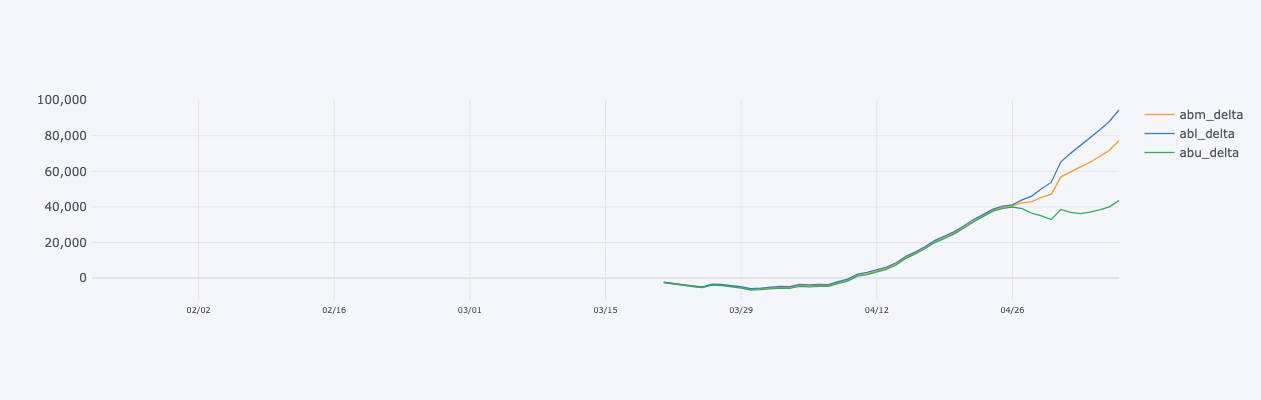

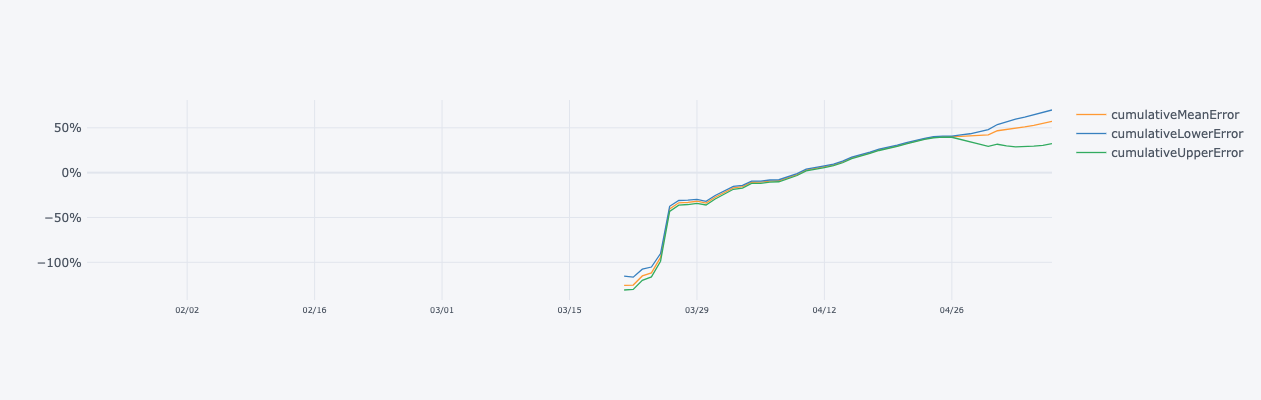

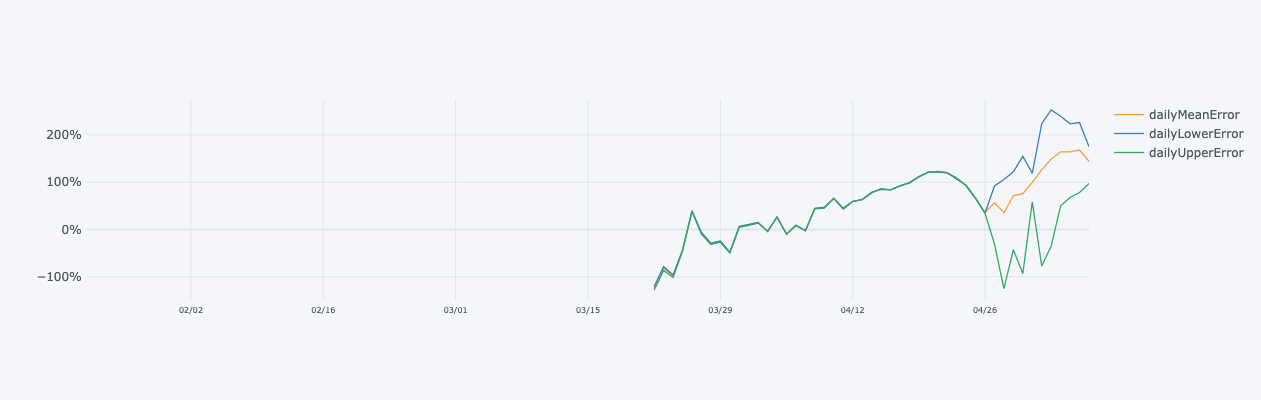

In [3]:
# COLUMN REFERENCE
# stats: states, positive, negative, pending, hospitalized, 
#        death, totalTestResults, deathIncrease, hospitalizedIncrease, 
#        negativeIncrease, positiveIncrease, totalTestResultsIncrease

# Drop columns not currently being used
drop_columns = ["total",
                "dateChecked",
                "hash",
                "posNeg",
               ]
covid_us.drop(columns=drop_columns, inplace=True)

# Load State Population file
with open('state_populations.json') as data:
    state_pop = pd.read_json(data)

us_pop = state_pop['population'].sum()

# Create new columns in covid dataframe
covid_us['infectionRate'] = covid_us['positive'].div(us_pop, fill_value=0)
covid_us['totalPositiveRate'] = covid_us['positive'].div(covid_us['totalTestResults'], fill_value=0)
covid_us['totalHospitalRate'] = covid_us['hospitalized'].div(covid_us['positive'], fill_value=0)
covid_us['totalDeathRate'] = covid_us['death'].div(covid_us['positive'], fill_value=0)
covid_us['newPositiveRate'] = covid_us['positiveIncrease'].div(covid_us['totalTestResultsIncrease'], fill_value=0)

# Convert date column to datetime

covid_us['date'] = pd.to_datetime(covid_us['date'], format="%Y%m%d")
source = ColumnDataSource(data=covid_us)

covid_us.head()

us_beds = pd.merge(left=covid_us, right=us_model, how='left', left_on='date', right_on='date')
us_beds = us_beds[['date', 'hospitalizedCumulative', 'allbed_mean', 'allbed_lower', 'allbed_upper', 'death', 'deathIncrease', 'deaths_mean', 'deaths_lower', 'deaths_upper']]
us_beds = us_beds.set_index('date')

for column, new_column in [('hospitalizedCumulative', 'hospInc'), 
                           ('allbed_mean', 'abmInc'),
                           ('allbed_lower', 'ablInc'),
                           ('allbed_upper', 'abuInc'),
                          ]:
    us_cum = us_beds[column].to_list()
    us_inc = []
    for i in range(len(us_cum)):
        if i < len(us_cum)-1:
            us_inc.append(us_cum[i]-us_cum[i+1])
        elif i == len(us_cum)-1:
            us_inc.append(0.0)
    us_beds[new_column] = np.array(us_inc)

us_beds['abm_delta'] = us_beds['hospitalizedCumulative'].sub(us_beds['allbed_mean'])
us_beds['abl_delta'] = us_beds['hospitalizedCumulative'].sub(us_beds['allbed_lower'])
us_beds['abu_delta'] = us_beds['hospitalizedCumulative'].sub(us_beds['allbed_upper'])
us_beds['abm_inc_delta'] = us_beds['hospInc'].sub(us_beds['abmInc'])
us_beds['abl_inc_delta'] = us_beds['hospInc'].sub(us_beds['ablInc'])
us_beds['abu_inc_delta'] = us_beds['hospInc'].sub(us_beds['abuInc'])
us_beds['dm_inc_delta'] = us_beds['deathIncrease'].sub(us_beds['deaths_mean'])
us_beds['dl_inc_delta'] = us_beds['deathIncrease'].sub(us_beds['deaths_lower'])
us_beds['du_inc_delta'] = us_beds['deathIncrease'].sub(us_beds['deaths_upper'])
us_beds['cumulativeMeanError'] = us_beds['abm_delta'].div(us_beds['hospitalizedCumulative'], fill_value=0)
us_beds['cumulativeLowerError'] = us_beds['abl_delta'].div(us_beds['hospitalizedCumulative'], fill_value=0)
us_beds['cumulativeUpperError'] = us_beds['abu_delta'].div(us_beds['hospitalizedCumulative'], fill_value=0)
us_beds['dailyMeanError'] = us_beds['abm_inc_delta'].div(us_beds['hospInc'], fill_value=0)
us_beds['dailyLowerError'] = us_beds['abl_inc_delta'].div(us_beds['hospInc'], fill_value=0)
us_beds['dailyUpperError'] = us_beds['abu_inc_delta'].div(us_beds['hospInc'], fill_value=0)
us_beds['dailyDeathMeanError'] = us_beds['dm_inc_delta'].div(us_beds['deathIncrease'], fill_value=0)
us_beds['dailyDeathLowerError'] = us_beds['dl_inc_delta'].div(us_beds['deathIncrease'], fill_value=0)
us_beds['dailyDeathUpperError'] = us_beds['du_inc_delta'].div(us_beds['deathIncrease'], fill_value=0)
us_beds.head(60)

us_beds_delta = us_beds[['abm_delta', 'abl_delta', 'abu_delta']]
us_beds_cumulative_error = us_beds[['cumulativeMeanError', 'cumulativeLowerError', 'cumulativeUpperError']]
us_beds_daily_error = us_beds[['dailyMeanError', 'dailyLowerError', 'dailyUpperError']]

fig = us_beds_delta.iplot(asFigure=True)
fig.layout.xaxis.tickformat = '%m/%d'
fig.layout.xaxis.tickfont.size = 8
fig.layout.yaxis.tickformat = '0,0'
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

fig = us_beds_cumulative_error.iplot(asFigure=True)
fig.layout.xaxis.tickformat = '%m/%d'
fig.layout.xaxis.tickfont.size = 8
fig.layout.yaxis.tickformat = '0%'
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

fig = us_beds_daily_error.iplot(asFigure=True)
fig.layout.xaxis.tickformat = '%m/%d'
fig.layout.xaxis.tickfont.size = 8
fig.layout.yaxis.tickformat = '0%'
fig.update_layout(
    autosize=False,
    width=600,
    height=400,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

## Charts

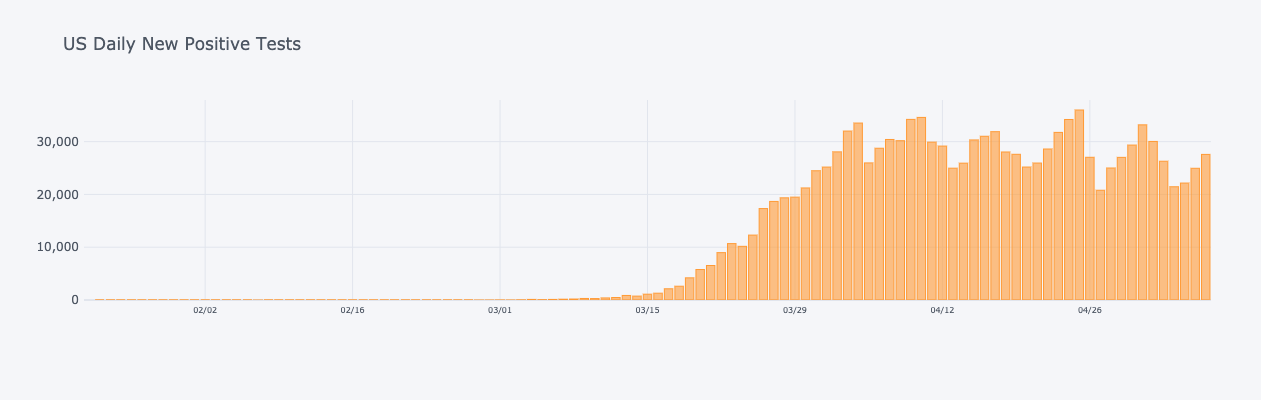

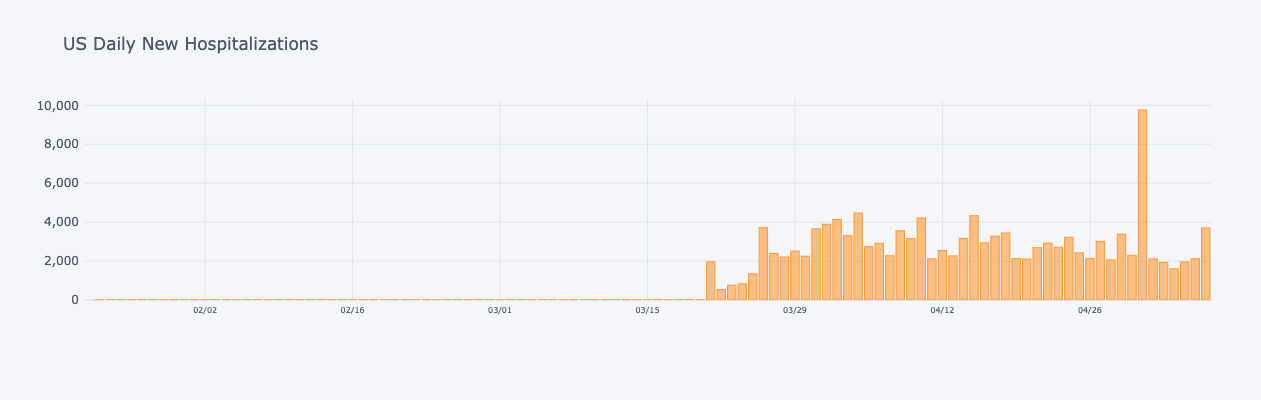

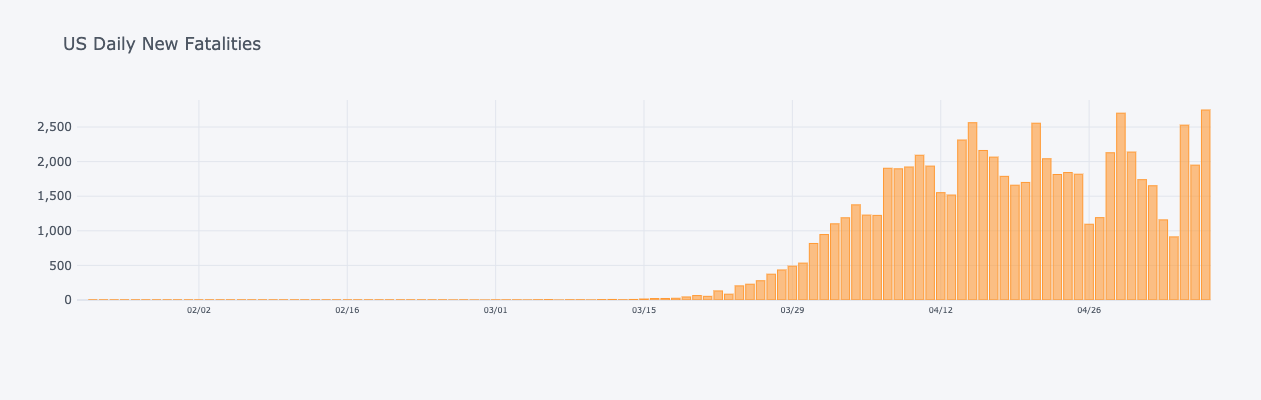

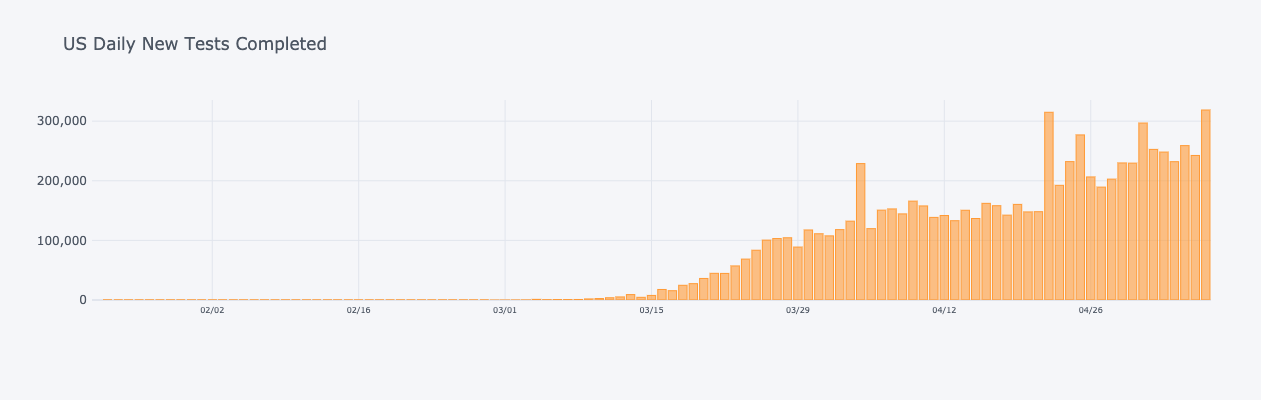

In [4]:
for stat, title in [('positiveIncrease', 'Positive Tests'),
             ('hospitalizedIncrease', 'Hospitalizations'),
             ('deathIncrease', 'Fatalities'),
             ('totalTestResultsIncrease', 'Tests Completed'),
            ]:
    new_df = covid_us[['date', stat]].set_index('date')
    fig = new_df.iplot(asFigure=True, kind="bar", title='US Daily New {}'.format(title))
    fig.layout.xaxis.tickformat = '%m/%d'
    fig.layout.xaxis.tickfont.size = 8
    fig.layout.yaxis.tickformat = '0,0'
    fig.update_layout(
            autosize=False,
            width=725,
            height=400,
            margin=dict(
                l=50,
                r=50,
                b=100,
                t=100,
                pad=4
            ),
        )
    fig.show()

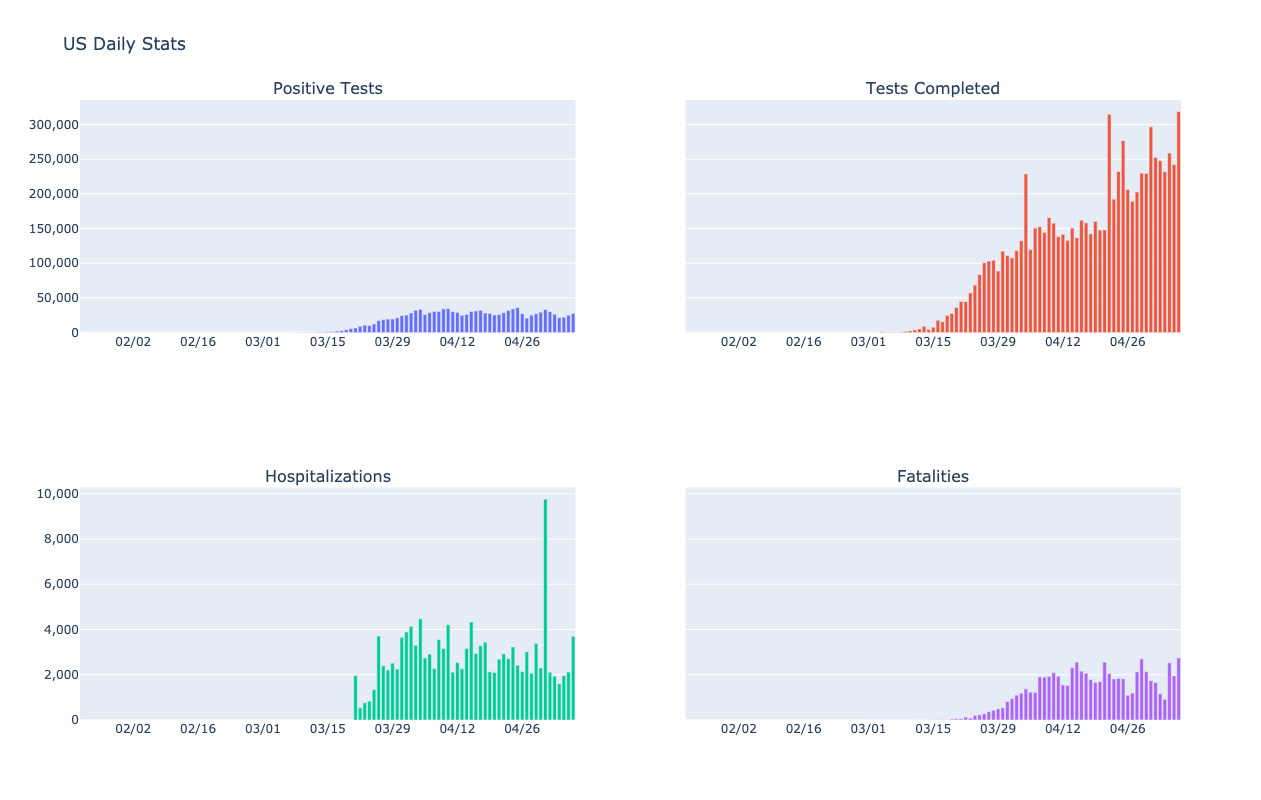

In [5]:

new_df = covid_us[['date', 'positiveIncrease', 'hospitalizedIncrease', 'deathIncrease', 'totalTestResultsIncrease']].set_index('date')

graph_datapoints = [('positiveIncrease', 'Positive Tests'),
                    ('totalTestResultsIncrease', 'Tests Completed'),
                    ('hospitalizedIncrease', 'Hospitalizations'),
                    ('deathIncrease', 'Fatalities'),
                   ]

# Initialize figure with subplots
fig = make_subplots(rows=2, 
                    cols=2, 
                    shared_yaxes=True,
                    subplot_titles=(graph_datapoints[0][1], graph_datapoints[1][1], graph_datapoints[2][1], graph_datapoints[3][1]),
                   )

# Add Traces
fig.add_trace(go.Bar(x=new_df.index, y=new_df.positiveIncrease), row=1, col=1)
fig.add_trace(go.Bar(x=new_df.index, y=new_df.totalTestResultsIncrease), row=1, col=2)
fig.add_trace(go.Bar(x=new_df.index, y=new_df.hospitalizedIncrease), row=2, col=1)
fig.add_trace(go.Bar(x=new_df.index, y=new_df.deathIncrease), row=2, col=2)

    
# Update X Axis Properties
fig.update_xaxes(tickformat='%m/%d', row=1, col=1)
fig.update_xaxes(tickformat='%m/%d', row=1, col=2)
fig.update_xaxes(tickformat='%m/%d', row=2, col=1)
fig.update_xaxes(tickformat='%m/%d', row=2, col=2)
    
# Update Y Axis Properties
fig.update_yaxes(tickformat='0,0', row=1, col=1)
fig.update_yaxes(tickformat='0,0', row=1, col=2)
fig.update_yaxes(tickformat='0,0', row=2, col=1)
fig.update_yaxes(tickformat='0,0', row=2, col=2)
    
fig.update_layout(title_text="US Daily Stats", showlegend=False, height=800, width=800)

fig.show()

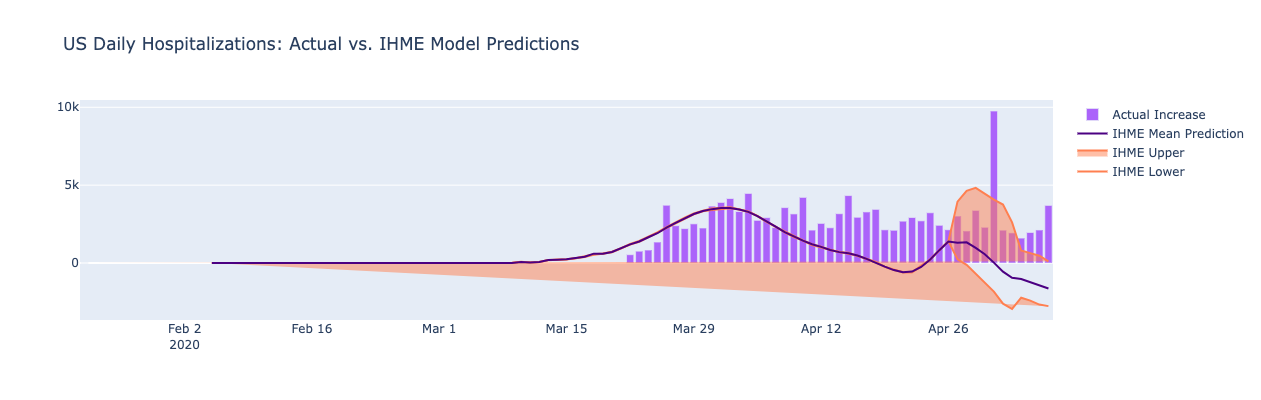

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.ablInc,
    fill=None,
    mode='lines',
    line_color='coral',
    name='IHME Lower',
    ))
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.abuInc,
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines',
    line_color='coral',
    name='IHME Upper',
    ))
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.abmInc,
    line_color='indigo',
    name='IHME Mean Prediction',
    ))
fig.add_trace(go.Bar(x=us_beds.index, y=us_beds.hospInc,
    name='Actual Increase',
    ))
fig.update_layout(title_text="US Daily Hospitalizations: Actual vs. IHME Model Predictions", height=400, width=600)
    
fig.show()

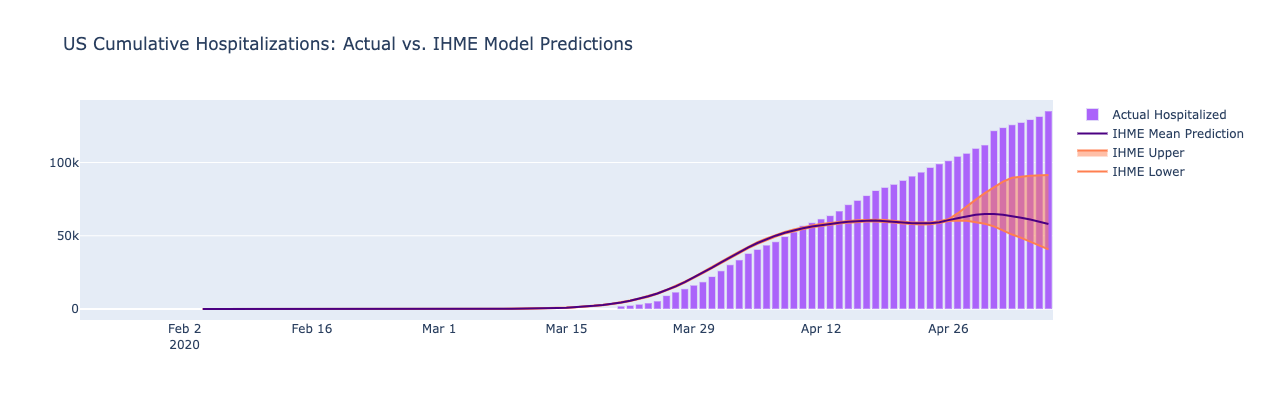

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.allbed_lower,
    fill=None,
    mode='lines',
    line_color='coral',
    name='IHME Lower',
    ))
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.allbed_upper,
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines',
    line_color='coral',
    name='IHME Upper',
    ))
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.allbed_mean,
    line_color='indigo',
    name='IHME Mean Prediction',
    ))
fig.add_trace(go.Bar(x=us_beds.index, y=us_beds.hospitalizedCumulative,
    name='Actual Hospitalized',
    ))
fig.update_layout(title_text="US Cumulative Hospitalizations: Actual vs. IHME Model Predictions", height=400, width=600)
    
fig.show()

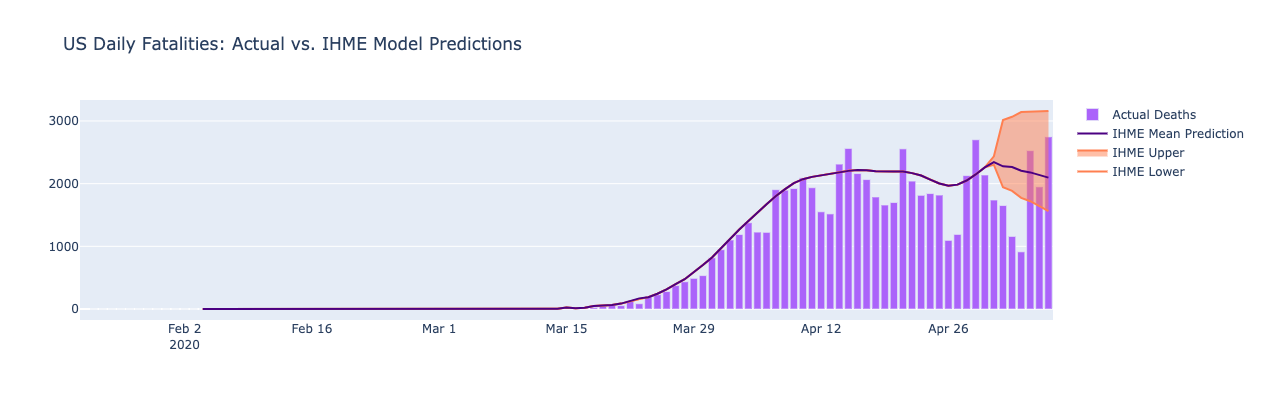

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.deaths_lower,
    fill=None,
    mode='lines',
    line_color='coral',
    name='IHME Lower',
    ))
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.deaths_upper,
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines',
    line_color='coral',
    name='IHME Upper',
    ))
fig.add_trace(go.Scatter(x=us_beds.index, y=us_beds.deaths_mean,
    line_color='indigo',
    name='IHME Mean Prediction',
    ))
fig.add_trace(go.Bar(x=us_beds.index, y=us_beds.deathIncrease,
    name='Actual Deaths',
    ))
fig.update_layout(title_text="US Daily Fatalities: Actual vs. IHME Model Predictions", height=400, width=600)
    
fig.show()